# SCALEの機能をFortran共有ライブラリとしてPythonから呼ぶ

SCALEを共有ライブラリとしてコンパイルすることで, SCALE内部の機能を, Fortranのサブルーチンを介して, Pythonから呼ぶことができます. ここではSCALEが提供しているサブルーチンを用い, 大気下層から持ち上げたパーセルの温度の鉛直プロファイルや, それに基づくCAPEを計算する例を示します. この機能を使うには, 以下のような手続きが必要になります.
* Fortran側
    * 共有ライブラリオプションをつけてコンパイルされたSCALEを用意
        * sysdep/Makedef*ファイル内で適宜"-fPIC"オプションをつけてmake
    * インターフェースsubroutineコードを用意
        * SCALE subroutineをcallする
        * Pythonスクリプトによってcallされる
* Python側
    * インターフェースsubroutineコードを共有ライブラリ化したものを, ctypesライブラリを使って呼び出す

具体的には, 以下のようにSCALE共有ライブラリとFortranのインターフェースサブルーチンを作成します.
#### SCALEのコンパイル（"5.3 SCALEライブラリの使い方"参照）
* sysdep/Makedef.*の変更 (オプションに-fPICを追加する)

```
FFLAGS_CORE = -cpp -m64 \
     -std=f2003 -fall-intrinsics -pedantic-errors -fimplicit-none -fmodule-private \
     -fconvert=big-endian -frecord-marker=4 -ffree-form -ffree-line-length-none \
     -fPIC
FFLAGS_DYN = $(FFLAGS) -fPIC
CFLAGS_FAST  = -O3 -m64 -fPIC
```
* 適切に環境変数(e.g., SCALE_SYS)を設定した上で, scale-5.5.1/scalelib/src 上でmake

#### インターフェースsubroutineコードのコンパイル
* 自作のFortranサブルーチンコードをコンパイルします(今回の例ではtest_scale_adiabat.f90)

    mpif90 -shared -fPIC -o test_scale_adiabat.so test_scale_adiabat.f90 -J scale-5.5.1/include \`nc-config --cflags\` -L scale-5.5.1/lib -lscale \`nc-config --libs\`


#### ※現在, SCALEライブラリを呼ぶ場合にPython側でMPI並列を使う方法は確立できていません.

## ライブラリの読込
* numpy: 数値計算ライブラリ
* xarray: 
* matplotlib: 描画ライブラリ
* ctypes: 外部関数ライブラリ. Fortranで作成した共有ライブラリを呼び出す.
* mod_scale.g_file: SCALE解析ライブラリ(ファイル関係). 現在いるディレクトリにリンクを貼っておく必要がある. (e.g., ln -s /home/hoge/mod_scale ./)

In [1]:
import numpy as np
import xarray as xr
from ctypes import *
import matplotlib.pyplot as plt
from mod_scale.g_file import get_xrvar, get_fpathlist
plt.rcParams["font.size"]=15

## データ情報の設定
* dir1: scale-rm/test/tutorial/real/experiment/run へのパス
* domainlabel: "_d01"などのドメインラベル. なければ""
* timelabel: "_20070714-210000.000"などの時間ラベル. なければ""
* PRC_NUM_X,PRC_NUM_Y: SCALE実行時に*.confに指定したプロセス数.

In [2]:
# Data setting
dir1 = "./sampledata/scale-5.4.5/scale-rm/test/tutorial/real/experiment/run/"

domainlabel = "_d01"
timelabel = ""

PRC_NUM_X = 2
PRC_NUM_Y = 2

dir_out = "./fig/"
savefig = True

## データ処理
* ファイルの読込
* Fortranサブルーチンとやりとりする入力・出力変数を準備

In [3]:
# Read history
fpathlist =  get_fpathlist(dir1,"history",domainlabel,timelabel,PRC_NUM_X,PRC_NUM_Y)
ds = get_xrvar(fpathlist)

lon = ds.coords["lon"].values
lat = ds.coords["lat"].values
x  = ds.coords["x"].values
y = ds.coords["y"].values
z = ds.coords["z"].values

# input
CZ = ds.coords["CZ"][2:-2].values.astype(np.float64)
FZ = ds.coords["FZ"][2:-2].values.astype(np.float64)
TEMP = ds["T"].values.astype(np.float64)
PRES = ds["PRES"].values.astype(np.float64)
QV = ds["QV"].values.astype(np.float64)
QC = np.zeros_like(TEMP) # ds["QC"].values[tind,:,yind,xind].astype(np.float64)
QR = np.zeros_like(TEMP) # ds["QR"].values[tind,:,yind,xind].astype(np.float64)
QI = np.zeros_like(TEMP) # ds["QI"].values[tind,:,yind,xind].astype(np.float64)
QS = np.zeros_like(TEMP) # ds["QS"].values[tind,:,yind,xind].astype(np.float64)
QG = np.zeros_like(TEMP) # ds["QG"].values[tind,:,yind,xind].astype(np.float64)
#
TA = c_int32(TEMP.shape[0])
KA = c_int32(TEMP.shape[1])
KS = c_int32(1)
KE = KA
JA = c_int32(TEMP.shape[2])
JS = c_int32(1)
JE = JA
IA = c_int32(TEMP.shape[3])
IS = c_int32(1)
IE = IA
kstr = 2
Kstr = c_int32(kstr)

# output
CAPE   = np.zeros( ( (TEMP.shape[0],TEMP.shape[2],TEMP.shape[3]) ) , dtype=np.float64)
CIN    = np.zeros( ( (TEMP.shape[0],TEMP.shape[2],TEMP.shape[3]) ) , dtype=np.float64)
LCL    = np.zeros( ( (TEMP.shape[0],TEMP.shape[2],TEMP.shape[3]) ) , dtype=np.float64)
LFC    = np.zeros( ( (TEMP.shape[0],TEMP.shape[2],TEMP.shape[3]) ) , dtype=np.float64)
LNB    = np.zeros( ( (TEMP.shape[0],TEMP.shape[2],TEMP.shape[3]) ) , dtype=np.float64)   
DENS_p = np.zeros_like( TEMP ,dtype=np.float64)
TEMP_p = np.zeros_like( TEMP ,dtype=np.float64)
BUOY_p = np.zeros_like( TEMP ,dtype=np.float64)
QV_p   = np.zeros_like( TEMP ,dtype=np.float64)


* Fortranサブルーチンを呼び計算

In [4]:
#print("(before) CAPE[0,0,0], CIN[0,0,0], LCL[0,0,0], LFC[0,0,0], LNB[0,0,0] =", CAPE[0,0,0], CIN[0,0,0], LCL[0,0,0], LFC[0,0,0], LNB[0,0,0])

intnumber   = 11 # no need to change
arraynumber = 19 # no need to change
f = np.ctypeslib.load_library("test_scale_adiabat.so",".")
f.test_scale_adiabat_.argtypes = [POINTER(c_int32) if tmp<=intnumber else np.ctypeslib.ndpointer(dtype=np.float64) for tmp in range(1, intnumber + arraynumber + 1)]
f.test_scale_adiabat_.restype = c_void_p
f.test_scale_adiabat_(
    byref(TA), byref(KA), byref(KS), byref(KE), byref(IA), byref(IS), byref(IE), byref(JA), byref(JS), byref(JE), byref(Kstr),
    TEMP, PRES, QV, QC, QR, QI, QS, QG, CZ, FZ,
    CAPE, CIN, LCL, LFC, LNB, DENS_p, TEMP_p, BUOY_p, QV_p
)
del f

#print("(after) CAPE[0,0,0], CIN[0,0,0], LCL[0,0,0], LFC[0,0,0], LNB[0,0,0] =", CAPE[0,0,0], CIN[0,0,0], LCL[0,0,0], LFC[0,0,0], LNB[0,0,0])



[Tomo:32724] shmem: mmap: an error occurred while determining whether or not /var/folders/20/816pt6953lv90cycx2l_v75c0000gn/T//ompi.Tomo.501/jf.0/467992576/sm_segment.Tomo.501.1be50000.0 could be created.


INFO  [IO_LOG_setup] The used config is output to the log.

INFO  [PROF_setup] Setup
INFO  [PROF_setup] Not found namelist. Default used.
&PARAM_PROF
 PROF_RAP_LEVEL=2          ,
 PROF_MPI_BARRIER=F,
 /

INFO  [PROF_setup] Rap output level              =            2
INFO  [PROF_setup] Add MPI_barrier in every rap? =  F

INFO  [CONST_setup] Setup
INFO  [CONST_setup] Not found namelist. Default used.
&PARAM_CONST
 CONST_RADIUS=  6371220.0000000000     ,
 CONST_OHM=  7.2920000000000000E-005,
 CONST_GRAV=  9.8066499999999994     ,
 CONST_RDRY=  287.04000000000002     ,
 CONST_CPDRY=  1004.6400000000000     ,
 CONST_LAPS=  6.4999999999999997E-003,
 CONST_PSTD=  101325.00000000000     ,
 CONST_PRE00=  100000.00000000000     ,
 CONST_TSTD=  288.14999999999998     ,
 CONST_THERMODYN_TYPE="EXACT                           ",
 CONST_SMALLPLANETFACTOR=  1.0000000000000000     ,
 /

INFO  [CONST_setup] List of constants 
      PI                                                : PI      =    3.1415

## 描画
* ある時刻・ある水平地点の, 環境場と持ち上げパーセルの, 温度鉛直プロファイル
    * tind, xind, yind: 時間と水平地点に関するインデックス
* 時間平均したCAPEの水平分布

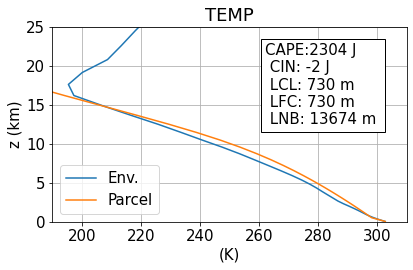

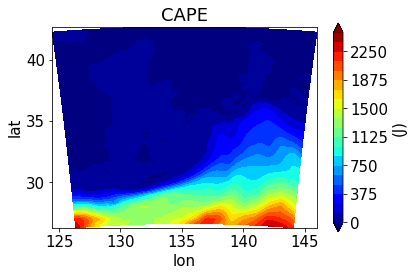

In [5]:
# Vertical profile of temperature for environment and lifted-parcel; CAPE and other parameters are attached as text
tind = 5
xind = 0
yind = 0

fig,ax=plt.subplots()
ax.plot(TEMP[tind,:,yind,xind], z*1e-3,label="Env.")
ax.plot(TEMP_p[tind,:,yind,xind], z*1e-3,label="Parcel")
ax.set_title("TEMP")
ax.text(0.6, 0.5, f"CAPE:{CAPE[tind,yind,xind]:.0f} J \n CIN: {CIN[tind,yind,xind]:.0f} J \n LCL: {LCL[tind,yind,xind]:.0f} m \n LFC: {LFC[tind,yind,xind]:.0f} m \n LNB: {LNB[tind,yind,xind]:.0f} m ", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=1.0))
ax.set_xlabel("(K)")
ax.set_ylabel("z (km)")
ax.set_xlim(190,310)
ax.set_ylim(0,25)
ax.grid()
ax.legend(loc="lower left")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out+"Parcel-TEMP.png")

# Horizontal distribution of tIme-averaged CAPE
fig,ax=plt.subplots()
cax = ax.contourf(lon,lat,np.mean(CAPE,axis=0),cmap="jet",levels=np.linspace(0,2500,21),extend="both")
cbar = plt.colorbar(cax,ax=ax)
cbar.set_label("(J)")
ax.set_title("CAPE")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_aspect("equal")
fig.tight_layout()
if savefig:
    fig.savefig(dir_out+f"CAPE_XY.png")
